# Dependencies and paths to datsets

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline


yt_path = "../data/youtube_clean.csv"
gd_path = "../data/gdelt_clean.csv"

# Read YouTube dataset

In [19]:
yt = pd.read_csv(yt_path)
print("YouTube clean shape:", yt.shape)
yt.head()

YouTube clean shape: (88436, 10)


,video_id,video_title,channel,video_published_at,comment_id,comment_text,comment_likes,comment_published_at,keyword,clean_comment_text
0,2IK3DFHRFfw,Generative AI in a Nutshell - how to survive a...,Henrik Kniberg,2024-01-20T15:47:20Z,Ugz3qfJEdXWWhCeyvCJ4AaABAg,Book version is now available on Amazon and Le...,151,2025-01-10T11:04:56Z,generative ai,book version is now available on amazon and le...
1,2IK3DFHRFfw,Generative AI in a Nutshell - how to survive a...,Henrik Kniberg,2024-01-20T15:47:20Z,UgzCxyYCK4SVJrfk9HJ4AaABAg,This is the most engaging tutorial I’ve ever s...,0,2025-12-07T06:59:40Z,generative ai,this is the most engaging tutorial i’ve ever s...
2,2IK3DFHRFfw,Generative AI in a Nutshell - how to survive a...,Henrik Kniberg,2024-01-20T15:47:20Z,Ugy6_tAXadZvaoMqa3l4AaABAg,"A very good place to start. Short, easy to und...",0,2025-12-05T20:21:48Z,generative ai,"a very good place to start. short, easy to und..."
3,2IK3DFHRFfw,Generative AI in a Nutshell - how to survive a...,Henrik Kniberg,2024-01-20T15:47:20Z,UgwdwVpipQuNmZ41X5B4AaABAg,Perfect video ! \nvery educational 👍🏻\nMany th...,0,2025-11-29T11:31:57Z,generative ai,perfect video ! very educational 👍🏻 many thanks
4,2IK3DFHRFfw,Generative AI in a Nutshell - how to survive a...,Henrik Kniberg,2024-01-20T15:47:20Z,Ugz4UrZMLsCfggZjxaZ4AaABAg,Amazing explanation. Thank-you,0,2025-11-28T05:23:54Z,generative ai,amazing explanation. thank-you


# Read GDELT dataset

In [20]:
gd = pd.read_csv(gd_path)
print("GDELT clean shape:", gd.shape)
gd.head()

GDELT clean shape: (53248, 8)


,url,title,language,published_at,keyword,source,published_at_dt,clean_title
0,https://www.crn.com/slide-shows/channel-progra...,Gartner : 12 Top Strategic Technology Trends F...,English,20220111T001500Z,generative ai,gdelt,2022-01-11 00:15:00+00:00,gartner : 12 top strategic technology trends f...
1,https://www.forbes.com/sites/forbesbusinesscou...,Preparing Businesses For The Metaverse And Omn...,English,20220131T134500Z,generative ai,gdelt,2022-01-31 13:45:00+00:00,preparing businesses for the metaverse and omn...
2,https://www.pinkvilla.com/tech/reviews/wiser-h...,Wiser Home Automation Kit Review : One - Stop ...,English,20220128T114500Z,generative ai,gdelt,2022-01-28 11:45:00+00:00,wiser home automation kit review : one - stop ...
3,http://www.itnewsonline.com/PRNewswire/Moviebo...,Moviebook CSAI Solution Facilitates Digital Tr...,English,20220105T081500Z,generative ai,gdelt,2022-01-05 08:15:00+00:00,moviebook csai solution facilitates digital tr...
4,https://www.prnewswire.com/news-releases/insil...,Insilico Medicine Announces the Nomination of ...,English,20220105T100000Z,generative ai,gdelt,2022-01-05 10:00:00+00:00,insilico medicine announces the nomination of ...


# Load RoBERTa model for sentiment analysis

In [21]:
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    truncation=True,
    max_length=256,
    batch_size=32,
    device=-1,  # CPU; set to 0 if you have GPU
)

'(ProtocolError('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer')), '(Request ID: 0d65e744-ab68-407a-858f-2ed6a6140297)')' thrown while requesting HEAD https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSeq

# Match sentiment label to a numeric value

In [22]:
LABEL_TO_VALUE = {
    "negative": -1,
    "neutral": 0,
    "positive": 1,
}

# Function that performs sentiment analysis on each row

In [23]:
def add_sentiment_columns(df: pd.DataFrame, text_col: str, batch_size: int = 32) -> pd.DataFrame:
    texts = df[text_col].fillna("").tolist()
    
    all_labels = []
    all_scores = []

    # tqdm gives progress bar in the notebook
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i : i + batch_size]
        results = sentiment_pipeline(batch)
        for r in results:
            all_labels.append(r["label"].lower())
            all_scores.append(float(r["score"]))

    df = df.copy()
    df["sentiment_label"] = all_labels
    df["sentiment_score"] = all_scores
    df["sentiment_value"] = df["sentiment_label"].map(LABEL_TO_VALUE)
    return df


# Sentiment analysis of YouTube dataset

In [24]:
yt_sent = add_sentiment_columns(yt, text_col="clean_comment_text", batch_size=32)

yt_sent[["clean_comment_text", "sentiment_label", "sentiment_score", "sentiment_value"]].head()
yt_sent["sentiment_label"].value_counts(normalize=True)

100%|██████████| 2764/2764 [2:10:25<00:00,  2.83s/it]    


sentiment_label
negative    0.378737
neutral     0.361482
positive    0.259781
Name: proportion, dtype: float64

# Sentiment analysis of GDELT dataset

In [25]:
gd_sent = add_sentiment_columns(gd, text_col="clean_title", batch_size=32)

gd_sent[["clean_title", "sentiment_label", "sentiment_score", "sentiment_value"]].head()
gd_sent["sentiment_label"].value_counts(normalize=True)

100%|██████████| 1664/1664 [11:29<00:00,  2.41it/s] 


sentiment_label
neutral     0.719407
positive    0.140700
negative    0.139893
Name: proportion, dtype: float64

# Save processed datasets with sentiment value

In [26]:
yt_sent_path = "../data/youtube_sentiment.csv"
gd_sent_path = "../data/gdelt_sentiment.csv"

yt_sent.to_csv(yt_sent_path, index=False)
gd_sent.to_csv(gd_sent_path, index=False)

yt_sent_path, gd_sent_path

('../data/youtube_sentiment.csv', '../data/gdelt_sentiment.csv')

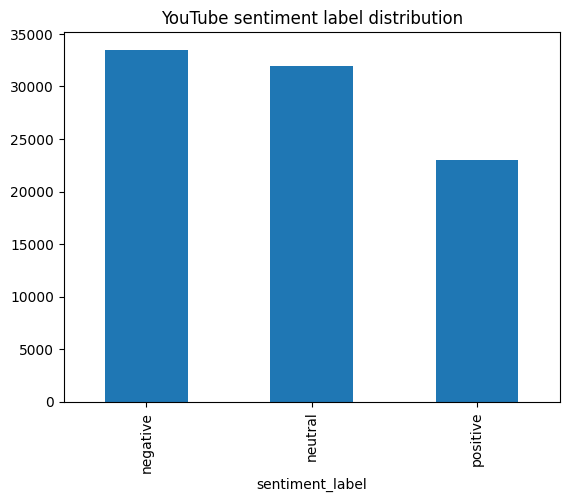

In [27]:
yt_sent["sentiment_label"].value_counts().plot(kind="bar")
plt.title("YouTube sentiment label distribution")
plt.show()

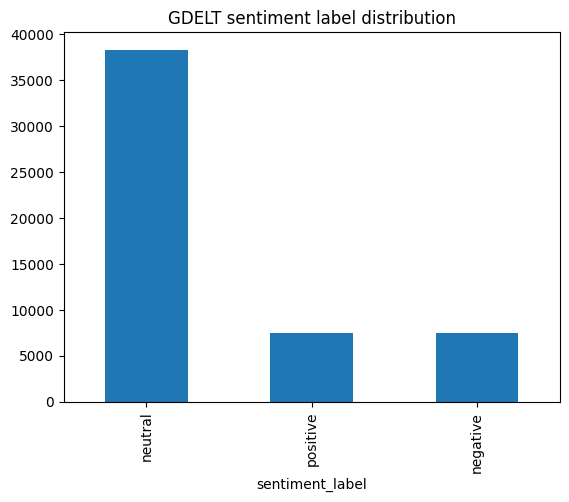

In [28]:
gd_sent["sentiment_label"].value_counts().plot(kind="bar")
plt.title("GDELT sentiment label distribution")
plt.show()